# Similarity to system archetypes

## Load the text and brain activation data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import binarize
from collections import OrderedDict

In [2]:
atlas_labels = pd.read_csv("../data/atlases/harvard-oxford.csv")
act_bin = pd.read_csv("../data/dcm_0mm_thres0.csv", index_col=0) # Previously binarized
act_bin = act_bin[atlas_labels["PREPROCESSED"]]
act_bin.mean().mean()

0.2984103746007817

In [3]:
def mean_thres(df):
    col_mean = df.mean()
    df_bin = np.empty((df.shape[0], df.shape[1]))
    i = 0
    for col, doc_mean in col_mean.iteritems():
        df_bin[:,i] = 1 * (df[col] > doc_mean)
        i += 1
    df_bin = pd.DataFrame(df_bin, columns=df.columns, index=df.index)
    return df_bin

In [4]:
dtm = pd.read_csv("../data/dtm_190124.csv.gz", compression="gzip", index_col=0)
dtm_bin = mean_thres(dtm)
dtm_bin.mean().mean()

0.019064029185168477

In [5]:
def score_lists(lists, dtm, label_var="LABEL"):
    dtm = pd.DataFrame(binarize(dtm, threshold=0), index=dtm.index, columns=dtm.columns)
    labels = OrderedDict.fromkeys(lists[label_var])
    list_counts = pd.DataFrame(index=dtm.index, columns=labels)
    for label in list_counts.columns:
        tkns = lists.loc[lists[label_var] == label, "TOKEN"]
        tkns = [token for token in tkns if token in dtm.columns]
        list_counts[label] = dtm[tkns].sum(axis=1)
    list_scores = mean_thres(list_counts)
    return list_scores

In [6]:
dom_lists = pd.read_csv("../lists/lists/lists_rdoc_domain_opsim.csv", index_col=None)

In [7]:
dom_scores = score_lists(dom_lists, dtm_bin, label_var="DOMAIN")

## Load the brain systems

In [8]:
pmids = [pmid for pmid in dom_scores.index if pmid in act_bin.index]
len(pmids)

18155

In [9]:
dom_scores = dom_scores.loc[pmids]
act_bin = act_bin.loc[pmids]

In [10]:
words = sorted(list(set(dom_lists["TOKEN"])))
structures = sorted(list(act_bin.columns))
domains = list(OrderedDict.fromkeys(dom_lists["DOMAIN"]))

In [11]:
circuits = pd.read_csv("../lists/circuits/circuits_domain_rdoc.csv", index_col=0)

In [12]:
dom_systems = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in dom_lists.loc[dom_lists["DOMAIN"] == dom, "TOKEN"]:
        dom_systems.loc[word, dom] = 1.0
    for struct in structures:
        dom_systems.loc[struct, dom] = circuits.loc[struct, dom]
dom_systems[dom_systems > 0.0] = 1.0

## Load document assignments

In [13]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [14]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

action  affect_perception  affective_state  aggression  alertness  \
1402966     0.0                0.0              0.0         0.0        0.0   
1410086     0.0                0.0              0.0         0.0        0.0   
1448149     0.0                0.0              0.0         0.0        0.0   
1486459     0.0                0.0              0.0         0.0        0.0   
1486460     0.0                0.0              0.0         0.0        0.0   

         anger  anticipation  anxiety  attachment  attention  ...  \
1402966    0.0           0.0      0.0         0.0        0.0  ...   
1410086    0.0           0.0      0.0         0.0        0.0  ...   
1448149    0.0           0.0      0.0         0.0        0.0  ...   
1486459    0.0           0.0      0.0         0.0        0.0  ...   
1486460    0.0           0.0      0.0         0.0        0.0  ...   

         right_superior_temporal_gyrus_posterior_division  \
1402966                                                 0   
1410086                                                 0   
1448149                                                 0   
1486459                                                 1   
1486460                                                 1   

         right_supplementary_motor_cortex  right_supracalcarine_cortex  \
1402966                                 0                            0   
1410086                                 0                            0   
1448149                                 0                            0   
1486459                                 0                            0   
1486460                                 0                            1   

         right_supramarginal_gyrus_anterior_division  \
1402966                                            0   
1410086                                            0   
1448149                                            0   
1486459                                            0   
1486460                                            0   

         right_supramarginal_gyrus_posterior_division  \
1402966                                             0   
1410086                                             0   
1448149                                             0   
1486459                                             0   
1486460                                             1   

         right_temporal_fusiform_cortex_anterior_division  \
1402966                                                 0   
1410086                                                 0   
1448149                                                 0   
1486459                                                 0   
1486460                                                 0   

         right_temporal_fusiform_cortex_posterior_division  \
1402966                                                  0   
1410086                                                  0   
1448149                                                  0   
1486459                                                  0   
1486460                                                  0   

         right_temporal_occipital_fusiform_cortex  right_temporal_pole  \
1402966                                         1                    0   
1410086                                         1                    0   
1448149                                         0                    1   
1486459                                         0                    0   
1486460                                         0                    0   

         right_thalamus  
1402966               0  
1410086               0  
1448149               0  
1486459               0  
1486460               0  

[5 rows x 229 columns]

In [15]:
doc2dom_df = pd.read_csv("../mod/data/doc2dom_rdoc_domain.csv", header=None, index_col=0)
doc2dom = {int(pmid): int(dom) for pmid, dom in doc2dom_df.iterrows()}

In [16]:
dom2docs = {dom: [] for dom in domains}
for doc, dom in doc2dom.iteritems():
    dom2docs[domains[dom-1]].append(doc)

## Compute similarity to archetype

In [17]:
from scipy.spatial.distance import cdist

In [18]:
sims = []
for dom in domains:
    dom_pmids = dom2docs[dom]
    dom_vecs = docs.loc[dom_pmids].values
    dom_arche = dom_systems[dom].values.reshape(1, dom_systems.shape[0])
    dom_sims = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
    sims.append(dom_sims)

In [19]:
df = pd.DataFrame({"OBSERVED": sims}, index=domains)
df.head(6)

OBSERVED
NEGATIVE_VALENCE      0.359129
POSITIVE_VALENCE      0.347520
COGNITIVE_SYSTEMS     0.415164
SOCIAL_PROCESSES      0.343315
AROUSAL_REGULATION    0.221519
SENSORIMOTOR_SYSTEMS  0.431600

### Bootstrap distributions

In [20]:
n_iter = 10000

In [21]:
df_boot = np.zeros((len(domains), n_iter))
for n in range(n_iter):
    boot = np.random.choice(range(len(docs.columns)), size=len(docs.columns), replace=True)
    for i, dom in enumerate(domains):
        dom_pmids = dom2docs[dom]
        dom_vecs = docs.loc[dom_pmids].values[:,boot]
        dom_arche = dom_systems.values[boot,i].reshape(1, dom_systems.shape[0])
        df_boot[i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
    if n % int(n_iter / 10.0) == 0:
        print("Processed {} iterations".format(n))

Processed 0 iterations
Processed 1000 iterations
Processed 2000 iterations
Processed 3000 iterations
Processed 4000 iterations
Processed 5000 iterations
Processed 6000 iterations
Processed 7000 iterations
Processed 8000 iterations
Processed 9000 iterations


In [22]:
df_boot = pd.DataFrame(df_boot, index=domains, columns=range(n_iter))
df_boot = df_boot.fillna(0.0)
df_boot.to_csv("data/arche_boot_rdoc_domain_{}iter.csv".format(n_iter))

### Null distributions

In [23]:
df_null = np.zeros((len(domains), n_iter))
for n in range(n_iter):
    null = np.random.choice(range(len(docs.columns)), size=len(docs.columns), replace=False)
    for i, dom in enumerate(domains):
        dom_pmids = dom2docs[dom]
        dom_vecs = docs.loc[dom_pmids].values
        dom_arche = dom_systems.values[null,i].reshape(1, dom_systems.shape[0])
        df_null[i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
    if n % int(n_iter / 10.0) == 0:
        print("Processed {} iterations".format(n))

Processed 0 iterations
Processed 1000 iterations
Processed 2000 iterations
Processed 3000 iterations
Processed 4000 iterations
Processed 5000 iterations
Processed 6000 iterations
Processed 7000 iterations
Processed 8000 iterations
Processed 9000 iterations


In [24]:
df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
df_null.to_csv("data/arche_null_rdoc_domain_{}iter.csv".format(n_iter))

### Confidence intervals

In [25]:
for dom in domains:
    
    dom_boot = sorted(list(df_boot.loc[dom]))
    df.loc[dom, "BOOT_CI_LOWER"] = dom_boot[int(float(n_iter)*0.05)]
    df.loc[dom, "BOOT_CI_UPPER"] = dom_boot[int(float(n_iter)*0.95)]
    
    dom_null = sorted(list(df_null.loc[dom]))
    df.loc[dom, "NULL_CI_LOWER"] = dom_null[int(float(n_iter)*0.05)]
    df.loc[dom, "NULL_CI_UPPER"] = dom_null[int(float(n_iter)*0.95)]
df

OBSERVED  BOOT_CI_LOWER  BOOT_CI_UPPER  NULL_CI_LOWER  \
NEGATIVE_VALENCE      0.359129       0.320123       0.391629       0.161580   
POSITIVE_VALENCE      0.347520       0.304387       0.384260       0.120540   
COGNITIVE_SYSTEMS     0.415164       0.366280       0.456578       0.168208   
SOCIAL_PROCESSES      0.343315       0.302505       0.377880       0.171447   
AROUSAL_REGULATION    0.221519       0.178102       0.259368       0.058195   
SENSORIMOTOR_SYSTEMS  0.431600       0.385376       0.469255       0.140816   

                      NULL_CI_UPPER  
NEGATIVE_VALENCE           0.223539  
POSITIVE_VALENCE           0.183416  
COGNITIVE_SYSTEMS          0.244511  
SOCIAL_PROCESSES           0.235798  
AROUSAL_REGULATION         0.109802  
SENSORIMOTOR_SYSTEMS       0.219194

### Comparison tests

In [21]:
from statsmodels.stats import multitest

In [22]:
df_boot = pd.read_csv("data/arche_boot_rdoc_domain_{}iter.csv".format(n_iter), index_col=0)
df_null = pd.read_csv("data/arche_null_rdoc_domain_{}iter.csv".format(n_iter), index_col=0)

In [23]:
pval = []
for dom in domains:   
    dom_boot = df_boot.loc[dom].values
    dom_null = df_null.loc[dom].values
    p = np.sum(np.less(dom_boot, np.max(dom_null))) / float(n_iter)
    pval.append(p)
    df.loc[dom, "P"] = p
df["P_COR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for dom in domains:
    for star, alpha in zip(["*", "**", "***"], [0.05, 0.01, 0.001]):
        if df.loc[dom, "P_COR"] < alpha:
            df.loc[dom, "STARS"] = star
df = df.loc[domains, ["OBSERVED", "P", "P_COR", "STARS"]]
df

OBSERVED       P    P_COR STARS
NEGATIVE_VALENCE      0.359129  0.0002  0.00030   ***
POSITIVE_VALENCE      0.347520  0.0001  0.00020   ***
COGNITIVE_SYSTEMS     0.415164  0.0000  0.00000   ***
SOCIAL_PROCESSES      0.343315  0.0048  0.00480    **
AROUSAL_REGULATION    0.221519  0.0009  0.00108    **
SENSORIMOTOR_SYSTEMS  0.431600  0.0000  0.00000   ***

### Violin plots

In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, rcParams
import warnings
warnings.simplefilter("ignore", UserWarning)
% matplotlib inline

In [25]:
arial = "../style/Arial Unicode.ttf"
prop = font_manager.FontProperties(fname=arial, size=20)
prop_lg = font_manager.FontProperties(fname=arial, size=24)
rcParams["axes.linewidth"] = 1.5

In [26]:
palette = ["#778AA3", "#CE7D69", "#77B58A", "#7D74A3", "#CEBE6D", "#BA7E39"]

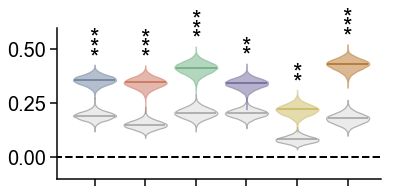

In [28]:
# Set up figure
fig = plt.figure(figsize=(4.5, 2.1))
ax = fig.add_axes([0,0,1,1])

for i, dom in enumerate(domains):
    
    # Null distribution
    data = sorted(df_null.loc[dom])
    obs = np.mean(data)
    plt.plot([i-0.37, i+0.38], [obs, obs], 
             c="#999999", alpha=0.7, lw=2)
    v = ax.violinplot(data, positions=[i], 
                      showmeans=False, showmedians=False, widths=0.85)
    for pc in v["bodies"]:
        pc.set_facecolor("#d8d8d8")
        pc.set_edgecolor("#6d6d6d")
        pc.set_linewidth(1.25)
        pc.set_alpha(0.5)
    for line in ["cmaxes", "cmins", "cbars"]:
        v[line].set_edgecolor("none")

    # Bootstrap distribution
    data = sorted(df_boot.loc[dom])
    obs = df["OBSERVED"][i]
    plt.plot([i-0.38, i+0.39], [obs, obs], 
             c=palette[i], alpha=1, lw=2)
    v = ax.violinplot(data, positions=[i], 
                      showmeans=False, showmedians=False, widths=0.85)
    for pc in v["bodies"]:
        pc.set_facecolor(palette[i])
        pc.set_edgecolor(palette[i])
        pc.set_linewidth(1.25)
        pc.set_alpha(0.55)
    for line in ["cmaxes", "cmins", "cbars"]:
        v[line].set_edgecolor("none")
        
    # Comparison test
    for alpha, dy in [(0.05, 0), (0.01, 0.045), (0.001, 0.09)]:
        if df.loc[dom, "P_COR"] <= alpha:
            plt.text(i-0.1, max(data) + dy, "*", fontproperties=prop_lg)
    
plt.plot([-1,len(domains)], [0, 0], 
         linestyle="dashed", c="k", alpha=1, linewidth=2)

# Set plot parameters
plt.xticks(range(len(domains)), [""]*len(domains))
plt.yticks([0, 0.25, 0.5], fontproperties=prop)
plt.xlim([-0.75, len(domains)-0.35])
plt.ylim([-0.1, 0.6])
for side in ["right", "top"]:
    ax.spines[side].set_visible(False)
ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)

# Export figure
plt.savefig("figures/arche_sims_rdoc_domain_{}iter.png".format(n_iter), 
            dpi=250, bbox_inches="tight")
plt.show()